In [14]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
logger = logging.getLogger(__name__)

In [15]:
def adjust_electricity_grid(n, year, years):
    """
    Add carrier to lines. Replace AC lines with DC links in case of line
    expansion. Add lifetime to DC links in case of line expansion.

    Parameters
    ----------
    n    : pypsa.Network
    year : int
           year in which optimized assets are built
    years: list
           investment periods
    """
    n.lines["carrier"] = "AC"
    links_i = n.links[n.links.carrier == "DC"].index
    if n.lines.s_nom_extendable.any() or n.links.loc[links_i, "p_nom_extendable"].any():
        hvdc_transport_model(n)
        links_i = n.links[n.links.carrier == "DC"].index
        n.links.loc[links_i, "lifetime"] = 100
        if year != years[0]:
            n.links.loc[links_i, "p_nom_min"] = 0
            n.links.loc[links_i, "p_nom"] = 0

def hvdc_transport_model(n):
    """
    Convert AC lines to DC links for multi-decade optimisation with line
    expansion.

    Losses of DC links are assumed to be 3% per 1000km
    """

    logger.info("Convert AC lines to DC links to perform multi-decade optimisation.")

    n.madd(
        "Link",
        n.lines.index,
        bus0 = n.lines.bus0,
        bus1 = n.lines.bus1,
        p_nom_extendable = True,
        p_nom = n.lines.s_nom,
        p_nom_min = n.lines.s_nom,
        p_min_pu = -1,
        efficiency = 1 - 0.03 * n.lines.length / 1000,
        marginal_cost = 0,
        carrier = "DC",
        length = n.lines.length,
        capital_cost = n.lines.capital_cost,
    )

    # Remove AC lines
    logger.info("Removing AC lines")
    lines_rm = n.lines.index
    n.mremove("Line", lines_rm)

    # Set efficiency of all DC links to include losses depending on length
    n.links.loc[n.links.carrier == "DC", "efficiency"] = (
        1 - 0.03 * n.links.loc[n.links.carrier == "DC", "length"] / 1000
    )


In [16]:
n = pypsa.Network()
years = [2020, 2030, 2040, 2050]
freq = "24"

snapshots = pd.DatetimeIndex([])
for year in years:
    period = pd.date_range(
        start="{}-01-01 00:00".format(year),
        freq="{}H".format(freq),
        periods=8760 / float(freq),
    )
    snapshots = snapshots.append(period)

# convert to multiindex and assign to network
n.snapshots = pd.MultiIndex.from_arrays([snapshots.year, snapshots])
n.investment_periods = years

In [17]:
n.investment_period_weightings["years"] = list(np.diff(years)) + [10]

r = 0.01
T = 0
for period, nyears in n.investment_period_weightings.years.items():
    discounts = [(1 / (1 + r) ** t) for t in range(T, T + nyears)]
    n.investment_period_weightings.at[period, "objective"] = sum(discounts)
    T += nyears

In [18]:
for i in range(3):
    n.add("Bus", "bus {}".format(i))

# add three lines in a ring
n.add(
    "Link",
    "line 0->1",
    bus0="bus 0",
    bus1="bus 1",
    p_min_pu = -1,
    p_nom=50,
    p_nom_extendable=False,
)

n.add(
    "Link",
    "line1 0->1",
    bus0="bus 0",
    bus1="bus 1",
    p_min_pu = -1,
    capital_cost=10,
    #build_year=2030,
    p_nom_extendable=True,
)


n.add(
    "Link",
    "line 1->2",
    bus0="bus 1",
    bus1="bus 2",
    capital_cost=10,
    p_min_pu = -1,
    build_year=2030,
    s_nom_extendable=True,
)

n.add(
    "Link",
    "line 2->0",
    bus0="bus 2",
    bus1="bus 0",
    p_min_pu = -1,
    p_nom_extendable=True,
)

#n.lines["x"] = 0.0001


In [19]:
n.lines

attribute,bus0,bus1,type,x,r,g,b,s_nom,s_nom_extendable,s_nom_min,...,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,


In [20]:
# add some generators
p_nom_max = pd.Series(
    (np.random.uniform() for sn in range(len(n.snapshots))),
    index=n.snapshots,
    name="generator ext 2020",
)

# renewable (can operate 2020, 2030)
n.add(
    "Generator",
    "generator ext 0 2020",
    bus="bus 0",
    p_nom=50,
    build_year=2020,
    lifetime=20,
    marginal_cost=2,
    capital_cost=1,
    p_max_pu=p_nom_max,
    carrier="solar",
    p_nom_extendable=True,
)

# can operate 2040, 2050
n.add(
    "Generator",
    "generator ext 0 2040",
    bus="bus 0",
    p_nom=50,
    build_year=2040,
    lifetime=11,
    marginal_cost=25,
    capital_cost=10,
    carrier="OCGT",
    p_nom_extendable=True,
)

# can operate in 2040
n.add(
    "Generator",
    "generator fix 1 2040",
    bus="bus 1",
    p_nom=50,
    build_year=2040,
    lifetime=10,
    carrier="CCGT",
    marginal_cost=20,
    capital_cost=1,
)

n.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
generator ext 0 2020,bus 0,PQ,,50.0,True,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
generator ext 0 2040,bus 0,PQ,,50.0,True,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
generator fix 1 2040,bus 1,PQ,,50.0,False,0.0,inf,0.0,1.0,0.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [21]:
n.add(
    "StorageUnit",
    "storageunit non-cyclic 2030",
    bus="bus 2",
    p_nom=0,
    capital_cost=2,
    build_year=2030,
    lifetime=21,
    cyclic_state_of_charge=False,
    p_nom_extendable=False,
)

n.add(
    "StorageUnit",
    "storageunit periodic 2020",
    bus="bus 2",
    p_nom=0,
    capital_cost=1,
    build_year=2020,
    lifetime=21,
    cyclic_state_of_charge=True,
    cyclic_state_of_charge_per_period=True,
    p_nom_extendable=True,
)

n.storage_units

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,
storageunit non-cyclic 2030,bus 2,PQ,,0.0,False,0.0,inf,-1.0,1.0,0.0,...,False,NaN,False,True,1.0,1.0,1.0,0.0,0.0,0.0
storageunit periodic 2020,bus 2,PQ,,0.0,True,0.0,inf,-1.0,1.0,0.0,...,False,NaN,True,True,1.0,1.0,1.0,0.0,0.0,0.0


Add the load

In [22]:
load_var = pd.Series(
    100 * np.random.rand(len(n.snapshots)), index=n.snapshots, name="load"
)
n.add("Load", "load 2", bus="bus 2", p_set=load_var)

load_fix = pd.Series(75, index=n.snapshots, name="load")
n.add("Load", "load 1", bus="bus 1", p_set=load_fix)

Run the optimization

In [23]:
n.loads_t.p_set

Load                  load 2  load 1
period timestep                     
2020   2020-01-01  10.730731    75.0
       2020-01-02  17.918723    75.0
       2020-01-03  75.358352    75.0
       2020-01-04  29.347668    75.0
       2020-01-05  27.660020    75.0
...                      ...     ...
2050   2050-12-27  42.484271    75.0
       2050-12-28  31.206125    75.0
       2050-12-29  69.478717    75.0
       2050-12-30  41.056118    75.0
       2050-12-31  51.272653    75.0

[1460 rows x 2 columns]

In [24]:

n.optimize.create_model(multi_investment_periods=True)
#n.remove_constraints("Kirchoff-Voltage-Law")
for year in n.investment_periods:
    adjust_electricity_grid(n, year, n.investment_periods)
n.optimize.solve_model(solver_name = "xpress", solver_options={"lpflags":4})

INFO:linopy.model: Solve problem using Xpress solver
INFO:linopy.model:Solver options:
 - lpflags: 4
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 10/10 [00:00<00:00, 525.52it/s]
INFO:linopy.io: Writing time: 0.17s


 
Reading Problem linopy-problem-jp2s_v1e
Problem Statistics
       36870 (      0 spare) rows
       13876 (      0 spare) structural columns
       66797 (      0 spare) non-zero elements
Global Statistics
           0 entities        0 sets        0 set members
FICO Xpress v8.14.2, Hyper, solve started 9:23:40, Nov 13, 2023
Heap usage: 10MB (peak 16MB, 7628KB system)
Minimizing LP linopy-problem-jp2s_v1e using up to 20 threads and up to 125GB memory, with these control settings:
OUTPUTLOG = 1
LPFLAGS = 4
Original problem has:
     36870 rows        13876 cols        66797 elements
Presolved problem has:
      6570 rows         4748 cols        16790 elements
Presolve finished in 0 seconds
Heap usage: 12MB (peak 25MB, 7628KB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 4.36e-04,  1.00e+00] / [ 2.08e-03,  1.00e+00]
  RHS and bounds [min,max] : [ 2.37e-01,  8.38e+03] / [ 4.33e-01,  1.75e+02]
  Objective      [min,m

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 13876 primals, 36870 duals
Objective: 1.81e+07
Solver model: available
Solver message: lp_optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [29]:
n.links.p_nom_opt

Link
line 0->1      50.000000
line1 0->1     25.000000
line 1->2       0.000000
line 2->0     300.284368
Name: p_nom_opt, dtype: float64

In [31]:
n.links_t.p0.loc[(2030,pd.date_range('2030-11-01','2030-11-20',freq="1H")),:]

/tmp/ipykernel_20292/3266437041.py:1: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  n.links_t.p0.loc[(2030,pd.date_range('2030-11-01','2030-11-20',freq="1H")),:]


Link               line 0->1  line1 0->1  line 1->2   line 2->0
period timestep                                                
2030   2030-11-01       50.0        25.0        0.0  -25.136816
       2030-11-02       50.0        25.0        0.0  -27.560699
       2030-11-03       50.0        25.0        0.0  -57.106174
       2030-11-04       50.0        25.0        0.0  -84.678226
       2030-11-05       50.0        25.0        0.0  -65.688837
       2030-11-06       50.0        25.0        0.0   -5.227076
       2030-11-07       50.0        25.0        0.0  -91.132920
       2030-11-08       50.0        25.0        0.0  -57.093077
       2030-11-09       50.0        25.0        0.0  -34.893409
       2030-11-10       50.0        25.0        0.0  -44.819993
       2030-11-11       50.0        25.0        0.0  -34.853228
       2030-11-12       50.0        25.0        0.0  -68.803614
       2030-11-13       50.0        25.0        0.0  -41.009195
       2030-11-14       50.0        25.0        0.0  -54.738907
       2030-11-15       50.0        25.0        0.0  -74.689003
       2030-11-16       50.0        25.0        0.0 -236.096079
       2030-11-17       50.0        25.0        0.0  -22.374265
       2030-11-18       50.0        25.0        0.0   42.981820
       2030-11-19       50.0        25.0        0.0    0.832318
       2030-11-20       50.0        25.0        0.0   41.984785

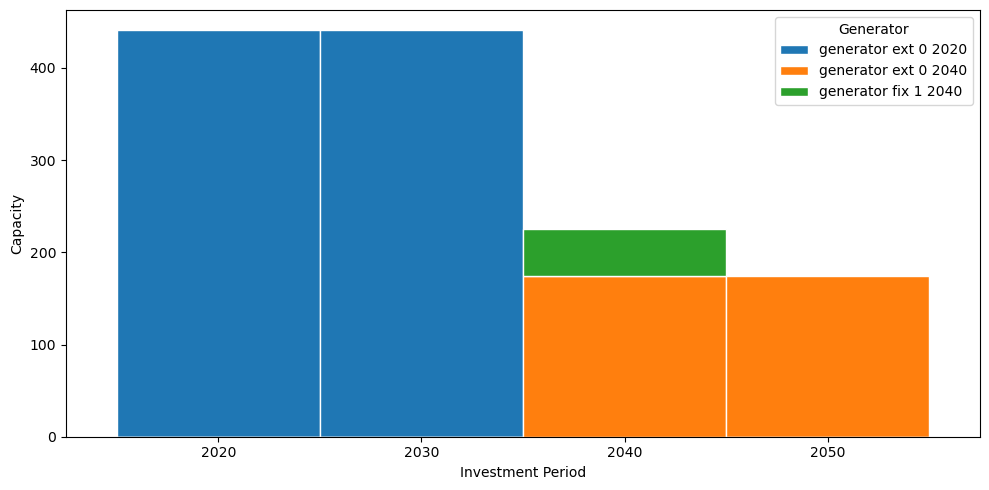

In [27]:
c = "Generator"
df = pd.concat(
    {
        period: n.get_active_assets(c, period) * n.df(c).p_nom_opt
        for period in n.investment_periods
    },
    axis=1,
)
df.T.plot.bar(
    stacked=True,
    edgecolor="white",
    width=1,
    ylabel="Capacity",
    xlabel="Investment Period",
    rot=0,
    figsize=(10, 5),
)
plt.tight_layout()

<AxesSubplot: xlabel='Investment Period', ylabel='Generation'>

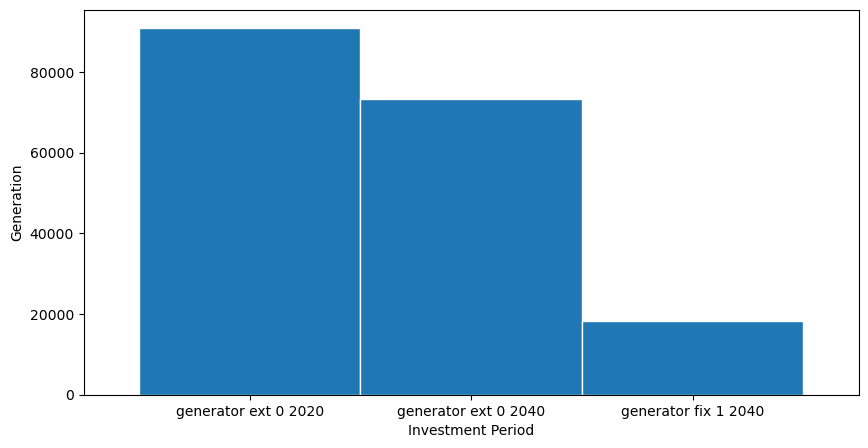

In [28]:
df = n.generators_t.p.sum(axis=0).T
df.T.plot.bar(
    stacked=True,
    edgecolor="white",
    width=1,
    ylabel="Generation",
    xlabel="Investment Period",
    rot=0,
    figsize=(10, 5),
)